# Algoritmo da Netflix

#### 2017 - UTFPR
https://gitlab.com/gabrielsouzaesilva 
https://github.com/cordeirolibel/ 
https://gitlab.com/mcampx 

In [1]:
import pandas as pd 
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from xml.dom.minidom import parse
import xml.dom.minidom
%matplotlib inline

### Parametros Globais

|A\B|1	2	3	4	5|
|:------------------:|
|1 |0	0	0	0	0|
|2 |0	0	0	0	0|
|3 |0	0	0	1	2|
|4 |0	-1	1	2	3|
|5 |-1	0	2	3	4|

Peso da aresta $A\rightarrow B$ em relação as notas dos filmes A e B por um mesmo usuario


In [2]:
weight_by_rate=[[ 0, 0, 0, 0, 0],\
                [ 0, 0, 0, 0, 0],\
                [ 0, 0, 0, 1, 2],\
                [ 0,-1, 1, 2, 3],\
                [-1, 0, 2, 3, 4]]
min_reliability = 6
imdb_rate_relevance = 0.01 # 1%

### Arrumando DataFrame

In [3]:
df = pd.read_csv('NetFlix.csv',dtype={'url': str})
df['movie'] = pd.Categorical(df['url']).codes

XML

In [4]:
# Open XML document using minidom parser
MovieXML = xml.dom.minidom.parse("movie.xml")
movies = MovieXML.documentElement

# Get all the movies min_weight = 0.57in the universe
movies = movies.getElementsByTagName("movie")

s71_data = list()
for movie in movies:
    url = movie.getAttribute('url')
    name = movie.getAttribute('name')
    rate = movie.getAttribute('rating')
    person = movie.getAttribute('person')

    #http://www.imdb.com/title/tt0086190/  ->  0086190
    url_cut = url[-8:-1]
    
    df.at[df['url']==url_cut,'name'] =  name
    df.at[df['url']==url_cut,'imdb'] =  rate
    df.at[df['url']==url_cut,'url'] =  url
    
    s71_data.append([person,name,url])
index = ['person','name','url']
df_s71 = pd.DataFrame(s71_data, columns = index)
df.head()

,user,rate,url,movie,name,imdb
0,0,3,http://www.imdb.com/title/tt0062622/,4,2001: A Space Odyssey,8.3
1,0,3,http://www.imdb.com/title/tt1345836/,48,The Dark Knight Rises,8.4
2,1,4,http://www.imdb.com/title/tt0133093/,26,The Matrix,8.7
3,1,3,http://www.imdb.com/title/tt1345836/,48,The Dark Knight Rises,8.4
4,1,3,http://www.imdb.com/title/tt0062622/,4,2001: A Space Odyssey,8.3


### Criando Grafo de Correlação

Craindo grafo zerado

In [5]:
n_movies = df['movie'].max()+1
n_users = df['user'].max()+1

G_correlation = nx.DiGraph()
    
edges = [(i,j,0.0) for i in range(n_movies) for j in range(n_movies) if i!=j]

G_correlation.add_weighted_edges_from(edges,weight='weight')
G_correlation.add_weighted_edges_from(edges,weight='reliability')
G_correlation.add_weighted_edges_from(edges,weight='reliability')

Para cada usuario analisar todas as relações

In [6]:
%%time
k = 0
for i_user in range(n_users):
    if k%10000 == 0:
        print(k,'/',n_users,'users')
    k+=1
    
    #only user i_user
    df_user = df[df['user']==i_user]
   
    #correlations
    previous_id = -1
    
    for index, row in df_user.iterrows():
        
        movie_id = row['movie']
        movie_rate = row['rate']
        #nao executa na primeira iteracao
        if previous_id != -1:
            weight1 = weight_by_rate[movie_rate-1][previous_rate-1]
            weight2 = weight_by_rate[previous_rate-1][movie_rate-1]

            G_correlation[movie_id][previous_id]['weight']+=weight1
            G_correlation[previous_id][movie_id]['weight']+=weight2
            
            G_correlation[previous_id][movie_id]['reliability']+=1
            G_correlation[movie_id][previous_id]['reliability']+=1
            
        previous_id = movie_id
        previous_rate = movie_rate

0 / 95029 users
10000 / 95029 users
20000 / 95029 users
30000 / 95029 users
40000 / 95029 users
50000 / 95029 users
60000 / 95029 users
70000 / 95029 users
80000 / 95029 users
90000 / 95029 users
CPU times: user 1min 34s, sys: 7.82 ms, total: 1min 34s
Wall time: 1min 34s


Tirando as medias e normalizando

In [7]:
#medias
for i in range(n_movies):
    for j in range(n_movies):
        if i!=j:
            if G_correlation[i][j]['reliability'] != 0:
                G_correlation[i][j]['weight'] /= G_correlation[i][j]['reliability']
                
#normalizando
ws = np.array(list(G_correlation.edges(data='weight')))[:,2]
w_min = ws.min()
w_max = ws.max()

for i in range(n_movies):
    for j in range(n_movies):
        if i!=j:
            if G_correlation[i][j]['reliability'] != 0:
                G_correlation[i][j]['weight'] -=w_min
                G_correlation[i][j]['weight'] /=(w_max-w_min)

Removendo pesos de ligações com pouca confiabilidade

In [8]:
edges_r = list(G_correlation.edges(data='reliability'))
edges_w = list(G_correlation.edges(data='weight'))
for e_r,e_w in zip(edges_r,edges_w):
    if e_r[2]<min_reliability or e_w[2] == 0:
        G_correlation.remove_edge(e_w[0],e_w[1])

## Draw

Grafo completo:

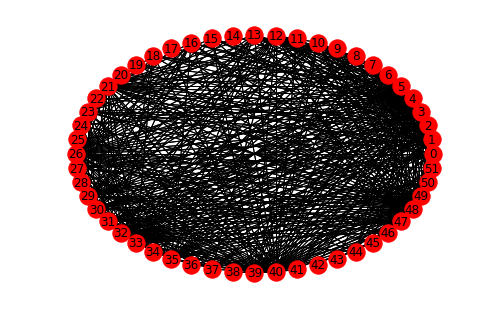

In [9]:
nx.draw_circular(G_correlation, with_labels = True,arrows=False)
plt.show()

Ligações mais fortes do grafo: 

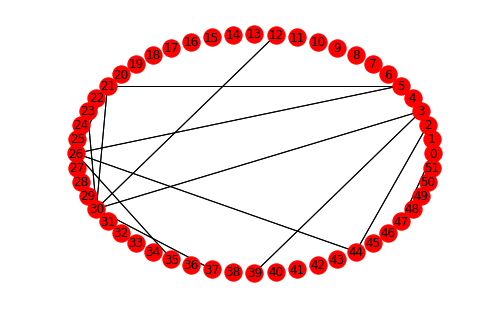

In [10]:
G = G_correlation.copy()
min_weight = 0.57

#removendo ligacoes fracas
edges_w = list(G.edges(data='weight'))
for e_w in edges_w:
    if e_w[2]<min_weight:
        G.remove_edge(e_w[0],e_w[1])

nx.draw_circular(G, with_labels = True,arrows=False)
plt.show()

In [11]:
movies_id = df.loc[:, ['movie','name']].drop_duplicates().sort_values('movie')
df_s71 = df_s71.merge(movies_id)
movies_id.set_index('movie')

,name
movie,
0,12 Angry Men
1,Psycho
2,Dr. Strangelove or: How I Learned to Stop Worr...
3,"Il buono, il brutto, il cattivo"
4,2001: A Space Odyssey
5,A Clockwork Orange
6,The Godfather
7,The Godfather: Part II
8,Star Wars


### Filmes mais conectados

In [12]:
edges_w = np.array(list(G_correlation.edges(data='weight')))
#sort
edges_w = edges_w[edges_w[:,2].argsort()][::-1]
top = edges_w[:,:2][:10]
top = list(set([tuple(i) for i in map(sorted, top)]))
for t in top:
    movie1 = movies_id[movies_id['movie']== t[0]]['name'].values[0]
    movie2 = movies_id[movies_id['movie']== t[1]]['name'].values[0]
    print('{:>20} {:>20}'.format(*[movie1,movie2]))

           Toy Story           The Matrix
           Toy Story       Monsters, Inc.
          The Matrix       Monsters, Inc.
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb               WALL*E
          The Matrix               WALL*E
Il buono, il brutto, il cattivo   A Clockwork Orange


## Recomendações

In [13]:
G = G_correlation.copy()

data_df = list()
people = df_s71['person'].drop_duplicates()
#para cada pessoa
for person in people:
    df_p = df_s71[df_s71['person']==person]
    
    #zerando recomendacoes do grafo
    nx.set_node_attributes(G,0, 'recommendation')

    #atualizando recomendacoes do grafo
    #para cada avaliacao de filme
    for index, row in df_p.iterrows():
        neighbors = set(G.neighbors(row['movie']))
        neighbors-=set(df_p['movie'])

        #para cada no conectado
        for nb in neighbors:
            w = G[row['movie']][nb]['weight']
            G.node[nb]['recommendation']+=w
            
    #normalizando
    recom = nx.get_node_attributes(G,'recommendation')
    r_min = min(recom.values())
    r_max = max(recom.values())
    recom = {key:(value-r_min)/(r_max-r_min) for key, value in recom.items()}
    
    #soma nota do imdb
    for key, value in recom.items():
        #nota do imdb
        imdb = float(df[df['movie']==key]['imdb'].values[0])
        recom[key] += imdb*imdb_rate_relevance

    #add dataframe
    top5 = np.array(sorted(recom.items(), key=lambda x: x[1]))[-5:][:,0]
    data = [person[33:]]
    for top in top5[::-1]:
        data.append(movies_id[movies_id['movie']== top]['name'].values[0])
    data_df.append(data)
index = ['person','movie1','movie2','movie3','movie4','movie5']
df_recom = pd.DataFrame(data_df,columns = index)
df_recom = df_recom.sort_values('person').reset_index(drop=True)
df_recom

,person,movie1,movie2,movie3,movie4,movie5
0,amandalima,The Matrix,Toy Story,"Monsters, Inc.","Il buono, il brutto, il cattivo",2001: A Space Odyssey
1,annabucharles,"Monsters, Inc.",The Matrix,"Il buono, il brutto, il cattivo",A Clockwork Orange,The Godfather
2,barbaraguerios,The Dark Knight Rises,Dr. Strangelove or: How I Learned to Stop Worr...,"Monsters, Inc.",The Matrix,Toy Story 3
3,fabianczajkowski,The Dark Knight Rises,2001: A Space Odyssey,El laberinto del fauno,Toy Story,Toy Story 3
4,gabrielfernandes,Kill Bill: Vol. 1,Toy Story,The Matrix,The Dark Knight Rises,2001: A Space Odyssey
5,gabrielsilva,A Clockwork Orange,El laberinto del fauno,Toy Story,2001: A Space Odyssey,Scarface
6,gustavolibel,The Matrix,Dr. Strangelove or: How I Learned to Stop Worr...,2001: A Space Odyssey,The Pianist,El laberinto del fauno
7,gustavopupo,Dr. Strangelove or: How I Learned to Stop Worr...,The Matrix,2001: A Space Odyssey,The Dark Knight Rises,El laberinto del fauno
8,igorlatini,The Matrix,A Clockwork Orange,El laberinto del fauno,2001: A Space Odyssey,The Pianist
9,katielensilva,2001: A Space Odyssey,Toy Story,The Dark Knight Rises,El laberinto del fauno,Dr. Strangelove or: How I Learned to Stop Worr...


## Validação

mean: 20.487179487179485
CPU times: user 7.27 s, sys: 23.8 ms, total: 7.3 s
Wall time: 7.37 s


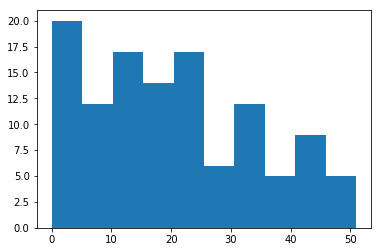

In [14]:
%%time
G = G_correlation.copy()

positions = list()
positions_sum = 0
k = 0
people = df_s71['person'].drop_duplicates()
#para cada pessoa
for person in people:
    df_p = df_s71[df_s71['person']==person]
    
    #nada a fazer com somente uma avaliacao
    if len(df_p)<= 1:
        continue 
        
    #para cada avaliacao/filme q fica de fora
    for i_out in range(len(df_p)):
        #removendo somente um filme
        df_p_reduced = df_p.drop(df_p.index[i_out])
        movie_out = df_p['movie'][df_p.index[i_out]]

        #zerando recomendacoes do grafo
        nx.set_node_attributes(G,0, 'recommendation')

        #atualizando recomendacoes do grafo
        #para cada avaliacao de filme
        for index, row in df_p_reduced.iterrows():
            neighbors = set(G.neighbors(row['movie']))
            neighbors-= set(df_p_reduced['movie'])

            #para cada no conectado
            for nb in neighbors:
                w = G[row['movie']][nb]['weight']
                G.node[nb]['recommendation']+=w

        #normalizando
        recom = nx.get_node_attributes(G,'recommendation')
        r_min = min(recom.values())
        r_max = max(recom.values())
        recom = {key:(value-r_min)/(r_max-r_min) for key, value in recom.items()}

        #soma nota do imdb
        for key, value in recom.items():
            #nota do imdb
            imdb = float(df[df['movie']==key]['imdb'].values[0])
            recom[key] += imdb*imdb_rate_relevance

        #procurando posicao
        ordered = list(np.array(sorted(recom.items(), key=lambda x: x[1]))[:,0][::-1])
        positions.append(ordered.index(movie_out))
        positions_sum+=positions[-1]
        k+=1
        
print('mean:',positions_sum/k)
plt.hist(positions,range = (0,len(movies_id)-1))